# Footprint | Polar Convexity

---------------------------

In this notebook we investigate how to encode/describe the shape of a buidling footprint and its rooms,using polar conv

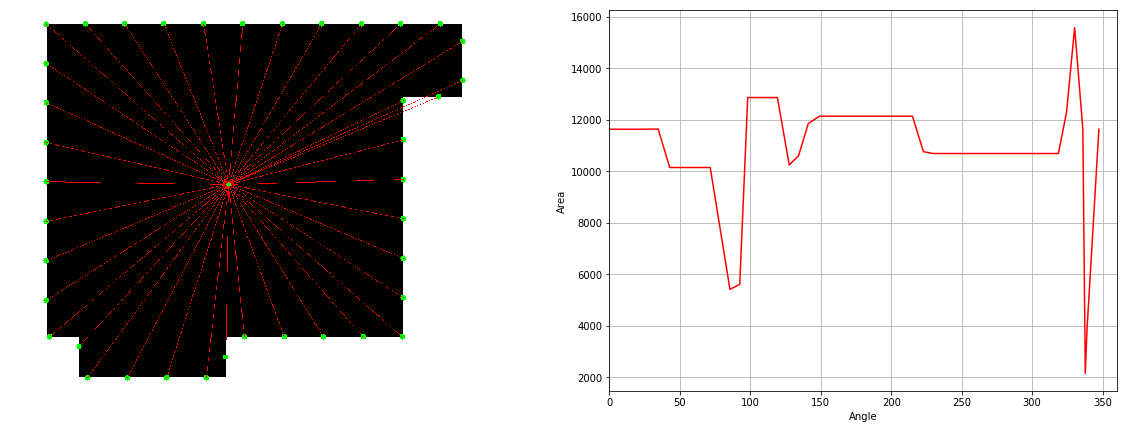

In [1]:
from IPython.display import Image
Image(filename='IMG/_ALL.png',width=1200, height=300)

-----------------------------

#### Import Data & Libraries

In [1]:
import pandas as pd
from IPython.display import Image
import cairo
import matplotlib.pylab as plt
import math
from IPython.display import Image
import numpy as np
from numpy import *
import glob
import os
import os.path
import time
import cv2
import random
import ast
from PIL import Image
from math import *

from scipy.ndimage.interpolation import geometric_transform
from scipy.spatial.distance import pdist, squareform, cdist

from skimage.morphology import skeletonize
from skimage import data
import sknw

import random

from shapely.geometry import LineString

In [4]:
#import data_list
data_list=pd.read_csv("CSV/dataset_23_07.csv")
data_list.head()

,path_to_txt,corrected,rooms,plan_clean,network_corrected,rooms_img,walls_corrected
0,.\vector_graphics_floorplans\representation_pr...,corrected/1.txt,rooms/1.txt,plan_clean/1.png,network_corrected/1.png,rooms_png/1.png,walls_corrected/1.png
1,.\vector_graphics_floorplans\representation_pr...,corrected/2.txt,rooms/2.txt,plan_clean/2.png,network_corrected/2.png,rooms_png/2.png,walls_corrected/2.png
2,.\vector_graphics_floorplans\representation_pr...,corrected/4.txt,rooms/4.txt,plan_clean/4.png,network_corrected/4.png,rooms_png/4.png,walls_corrected/4.png
3,.\vector_graphics_floorplans\representation_pr...,corrected/5.txt,rooms/5.txt,plan_clean/5.png,network_corrected/5.png,rooms_png/5.png,walls_corrected/5.png
4,.\vector_graphics_floorplans\representation_pr...,corrected/6.txt,rooms/6.txt,plan_clean/6.png,network_corrected/6.png,rooms_png/6.png,walls_corrected/6.png


--------------------------------------------------

## (1) Convexity Map of Contour

In [11]:
#Image(filename='IMG/2.JPG',width=600, height=300)

In [5]:
def triangle_area(x1, y1, x2, y2, x3, y3):
    return abs(0.5*(x1*(y2-y3)+x2*(y3-y1)+x3*(y1-y2)))
def get_length(x1,y1,x2,y2):
    return math.hypot(x2 - x1, y2 - y1)

#### Convexity footprint

In [16]:
def get_convexity_map(nb_points, id_image,print_):

    #load corrected plan
    data = pd.read_csv("../Pan DB Explorations/"+data_list.loc[id_image]["corrected"], sep="\t",header = None)
    data.columns = ["xmin", "ymin", "xmax", "ymax","category","dump1","dump2"]
    categories=['living_room','kitchen','bedroom','bathroom','restroom','balcony','washing_room',"balcony","toilet"]

    #load room dataframe
    data_rooms=pd.read_csv("../Pan DB Explorations/"+data_list.loc[id_image]["rooms"], header=None , sep=':')
    rooms_ = []
    points_ = []
    for i in range(len(data_rooms)):
        a = data_rooms.loc[i].values
        try:
            points = ast.literal_eval(a[1])
        except:
            points = [[0.0,0.0]]
        points_.append(points)
        try:
            rooms = a[0].split(",")
        except:
            rooms = "NaN"
        rooms_.append(rooms)
    data_room = pd.DataFrame()
    data_room["rooms"] = rooms_
    data_room["points"] = points_

    padding = 50
    stroke = 3

    xmin = np.min(data["xmin"])
    xmax = np.max(data["xmax"])
    ymin = np.min(data["ymin"]) 
    ymax = np.max(data["ymax"])

    WIDTH = int(xmax - xmin + padding)
    HEIGHT = int(ymax - ymin + padding)

    surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, WIDTH, HEIGHT)
    ctx = cairo.Context(surface)

    cx_ = []
    cy_ = []

    cx_pt = []
    cy_pt = []
    #SET BACKGROUND---------------
    ctx.rectangle(0.0, 0.0, WIDTH,HEIGHT)
    ctx.set_source_rgb(1, 1, 1)
    ctx.fill()

    #DRAW ROOMS LIGHT GREY
    for i in range(len(data_room)):

        ctx.move_to(data_room.loc[i]["points"][0][0]+padding/2-xmin, data_room.loc[i]["points"][0][1]+padding/2-ymin)

        for j in range(len(data_room.loc[i]["points"])):

            ctx.line_to(data_room.loc[i]["points"][j][0]+padding/2-xmin, data_room.loc[i]["points"][j][1]+padding/2-ymin)

        ctx.set_source_rgb(0, 0, 0)
        ctx.close_path()
        ctx.fill()


    surface.write_to_png(str(id_image)+".png") 
    img_ = cv2.cvtColor(cv2.imread(str(id_image)+".png"),cv2.COLOR_BGR2RGB)

    black_plan = img_.copy()

    #GET CONTOUR---------------------------------------------------------------------------------
    imgray = cv2.cvtColor(img_,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(imgray,127,255,0)
    im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    #get center of mass point
    cnt = contours[1]
    M = cv2.moments(cnt)
    Cx = int(M['m10']/M['m00'])
    Cy = int(M['m01']/M['m00'])

    #get points along contour
    pts= []

    for i in range(1,len(contours)):
        cnt = contours[i].reshape((contours[i].shape[0],2))
        end_ = np.array(cnt[0]).reshape((1,2))
        cnt = np.concatenate((cnt,end_),axis=0)
        line_ = LineString(cnt)
        values = np.linspace(0,line_.length, num=nb_points)

        #get value along polyline
        for val in values:
            pt = line_.interpolate(val)
            pts.append([pt.x,pt.y])

    areas = []
    angles = []
    ortho_point = [img_.shape[1],Cy]
    v1 = [ortho_point[0]-Cx,ortho_point[1]-Cy]
    j= 0
    for pt in pts:
        if(print_==True): 
            cv2.circle(img_,(int(pt[0]),int(pt[1])), 5, (0,255,0), -1) 
            cv2.line(img_,(int(pt[0]),int(pt[1])),(Cx,Cy),(255,0,0),1)
        if(j<len(pts)-1):
            ar_ = triangle_area(pts[j][0], pts[j][1], pts[j+1][0], pts[j+1][1], Cx, Cy)
            areas.append(ar_)
            v2 = [pt[0]-Cx,pt[1]-Cy]
            dot = v1[0]*v2[0] + v1[1]*v2[1]   
            det = v1[0]*v2[1] - v1[1]*v2[0]     
            angle = atan2(det, dot)  
            angles.append(angle)

        j=j+1

    #recenter angles to origin + to degrees
    angles_adjusted_d = np.degrees(np.array(angles) - angles[np.argmin(np.abs(angles))])
    angles_adjusted_d[angles_adjusted_d<0]= 360 + angles_adjusted_d[angles_adjusted_d<0]

    # add center point
    cv2.circle(img_,(int(Cx),int(Cy)), 4, (0,255,0), -1) 

    index_ = np.argsort(angles_adjusted_d)
    angles_adjusted_d_ = np.sort(angles_adjusted_d)
    areas_ = [areas[i] for i in index_]

    if(print_==True):   
        fig,ax = plt.subplots(1,2,figsize=(20,7))
        ax[0].imshow(img_)
        ax[0].axis("off")

        ax[1].plot(angles_adjusted_d_,areas_, color='r')
        ax[1].set_xlim([0, 360])
        ax[1].set_xlabel("Angle")
        ax[1].set_ylabel("Area")

        plt.grid()
    
    return angles_adjusted_d_,areas_

In [ ]:
def get_convexity_map(nb_points, id_image,print_):

    #load corrected plan
    data = pd.read_csv("../Pan DB Explorations/"+data_list.loc[id_image]["corrected"], sep="\t",header = None)
    data.columns = ["xmin", "ymin", "xmax", "ymax","category","dump1","dump2"]
    categories=['living_room','kitchen','bedroom','bathroom','restroom','balcony','washing_room',"balcony","toilet"]

    #load room dataframe
    data_rooms=pd.read_csv("../Pan DB Explorations/"+data_list.loc[id_image]["rooms"], header=None , sep=':')
    rooms_ = []
    points_ = []
    for i in range(len(data_rooms)):
        a = data_rooms.loc[i].values
        try:
            points = ast.literal_eval(a[1])
        except:
            points = [[0.0,0.0]]
        points_.append(points)
        try:
            rooms = a[0].split(",")
        except:
            rooms = "NaN"
        rooms_.append(rooms)
    data_room = pd.DataFrame()
    data_room["rooms"] = rooms_
    data_room["points"] = points_

    padding = 50
    stroke = 3

    xmin = np.min(data["xmin"])
    xmax = np.max(data["xmax"])
    ymin = np.min(data["ymin"]) 
    ymax = np.max(data["ymax"])

    WIDTH = int(xmax - xmin + padding)
    HEIGHT = int(ymax - ymin + padding)

    surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, WIDTH, HEIGHT)
    ctx = cairo.Context(surface)

    cx_ = []
    cy_ = []

    cx_pt = []
    cy_pt = []
    #SET BACKGROUND---------------
    ctx.rectangle(0.0, 0.0, WIDTH,HEIGHT)
    ctx.set_source_rgb(1, 1, 1)
    ctx.fill()

    #DRAW ROOMS LIGHT GREY
    for i in range(len(data_room)):

        ctx.move_to(data_room.loc[i]["points"][0][0]+padding/2-xmin, data_room.loc[i]["points"][0][1]+padding/2-ymin)

        for j in range(len(data_room.loc[i]["points"])):

            ctx.line_to(data_room.loc[i]["points"][j][0]+padding/2-xmin, data_room.loc[i]["points"][j][1]+padding/2-ymin)

        ctx.set_source_rgb(0, 0, 0)
        ctx.close_path()
        ctx.fill()


    surface.write_to_png(str(id_image)+".png") 
    img_ = cv2.cvtColor(cv2.imread(str(id_image)+".png"),cv2.COLOR_BGR2RGB)

    black_plan = img_.copy()

    #GET CONTOUR---------------------------------------------------------------------------------
    imgray = cv2.cvtColor(img_,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(imgray,127,255,0)
    im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    #get center of mass point
    cnt = contours[1]
    M = cv2.moments(cnt)
    Cx = int(M['m10']/M['m00'])
    Cy = int(M['m01']/M['m00'])

    #get points along contour
    pts= []

    for i in range(1,len(contours)):
        cnt = contours[i].reshape((contours[i].shape[0],2))
        end_ = np.array(cnt[0]).reshape((1,2))
        cnt = np.concatenate((cnt,end_),axis=0)
        line_ = LineString(cnt)
        values = np.linspace(0,line_.length, num=nb_points)

        #get value along polyline
        for val in values:
            pt = line_.interpolate(val)
            pts.append([pt.x,pt.y])

    areas = []
    angles = []
    ortho_point = [img_.shape[1],Cy]
    v1 = [ortho_point[0]-Cx,ortho_point[1]-Cy]
    j= 0
    for pt in pts:
        if(print_==True): 
            cv2.circle(img_,(int(pt[0]),int(pt[1])), 5, (0,255,0), -1) 
            cv2.line(img_,(int(pt[0]),int(pt[1])),(Cx,Cy),(255,0,0),1)
        if(j<len(pts)-1):
            ar_ = triangle_area(pts[j][0], pts[j][1], pts[j+1][0], pts[j+1][1], Cx, Cy)
            areas.append(ar_)
            v2 = [pt[0]-Cx,pt[1]-Cy]
            dot = v1[0]*v2[0] + v1[1]*v2[1]   
            det = v1[0]*v2[1] - v1[1]*v2[0]     
            angle = atan2(det, dot)  
            angles.append(angle)

        j=j+1

    #recenter angles to origin + to degrees
    angles_adjusted_d = np.degrees(np.array(angles) - angles[np.argmin(np.abs(angles))])
    angles_adjusted_d[angles_adjusted_d<0]= 360 + angles_adjusted_d[angles_adjusted_d<0]

    # add center point
    cv2.circle(img_,(int(Cx),int(Cy)), 4, (0,255,0), -1) 

    index_ = np.argsort(angles_adjusted_d)
    angles_adjusted_d_ = np.sort(angles_adjusted_d)
    areas_ = [areas[i] for i in index_]

    if(print_==True):   
        fig,ax = plt.subplots(1,2,figsize=(20,7))
        ax[0].imshow(img_)
        ax[0].axis("off")

        ax[1].plot(angles_adjusted_d_,areas_, color='r')
        ax[1].set_xlim([0, 360])
        ax[1].set_xlabel("Angle")
        ax[1].set_ylabel("Area")

        plt.grid()
    
    return angles_adjusted_d_,areas_

In [59]:
Angles_1, Areas_1 = get_convexity_map(nb_points=40, id_image=120 , print_=False)

In [57]:
Angles_2, Areas_2 = get_convexity_map(nb_points=40, id_image=121, print_=False)

In [53]:
Angles_3, Areas_3 = get_convexity_map(nb_points=40, id_image=210, print_=False)

#### Compare

In [42]:
def dist(a,b):
    
    #shift array
    d = np.tile(a, (len(a), 1))
    r=np.arange(len(b))
    rows, column_indices = np.ogrid[:d.shape[0], :d.shape[1]]
    r[r < 0] += d.shape[1]
    column_indices = column_indices - r[:,np.newaxis]
    d_shifted= d[rows, column_indices]
    diff = np.square(d_shifted - b)
    return np.min(np.sum(diff , axis=1))

In [58]:
dist(Areas_1,Areas_2)

16812430811.32695

#### Convexity for rooms

In [36]:
def get_convexity_rooms(id_image, print_):

    #MAKE BLACK PLAN--------------------------------------------------------------------------------------------------------
    data = pd.read_csv("../Pan DB Explorations/"+data_list.loc[id_image]["corrected"], sep="\t",header = None)
    data.columns = ["xmin", "ymin", "xmax", "ymax","category","dump1","dump2"]
    categories=['living_room','kitchen','bedroom','bathroom','restroom','balcony','washing_room',"balcony","toilet"]

    #load room dataframe
    data_rooms=pd.read_csv("../Pan DB Explorations/"+data_list.loc[id_image]["rooms"], header=None , sep=':')
    rooms_ = []
    points_ = []
    for i in range(len(data_rooms)):
        a = data_rooms.loc[i].values
        try:
            points = ast.literal_eval(a[1])
        except:
            points = [[0.0,0.0]]
        points_.append(points)
        try:
            rooms = a[0].split(",")
        except:
            rooms = "NaN"
        rooms_.append(rooms)
    data_room = pd.DataFrame()
    data_room["rooms"] = rooms_
    data_room["points"] = points_

    padding = 50
    stroke = 3

    xmin = np.min(data["xmin"])
    xmax = np.max(data["xmax"])
    ymin = np.min(data["ymin"]) 
    ymax = np.max(data["ymax"])

    WIDTH = int(xmax - xmin + padding)
    HEIGHT = int(ymax - ymin + padding)

    surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, WIDTH, HEIGHT)
    ctx = cairo.Context(surface)

    cx_ = []
    cy_ = []

    cx_pt = []
    cy_pt = []

    #SET BACKGROUND---------------
    ctx.rectangle(0.0, 0.0, WIDTH,HEIGHT)
    ctx.set_source_rgb(1, 1, 1)
    ctx.fill()

    #DRAW ROOMS LIGHT GREY
    for i in range(len(data_room)):

        ctx.move_to(data_room.loc[i]["points"][0][0]+padding/2-xmin, data_room.loc[i]["points"][0][1]+padding/2-ymin)

        for j in range(len(data_room.loc[i]["points"])):

            ctx.line_to(data_room.loc[i]["points"][j][0]+padding/2-xmin, data_room.loc[i]["points"][j][1]+padding/2-ymin)

        ctx.set_source_rgb(0, 0, 0)
        ctx.close_path()
        ctx.fill()

    surface.write_to_png(str(id_image)+".png") 
    img_ = cv2.cvtColor(cv2.imread(str(id_image)+".png"),cv2.COLOR_BGR2RGB)

    black_plan = img_.copy()

    #get polylines
    points_ = []
    for i in range(len(data_rooms)):
        a = data_rooms.loc[i].values
        try:
            points = ast.literal_eval(a[1])
        except:
            points = [[0.0,0.0]]
        points_.append(points)

    #FOR EACH ROOM --------------------------------------------------------------------------------------------------
    ANGLES = []
    AREAS = []
    
    for k in range(len(points_)):
        #nb of points to sample
        nb_points = 40
        #copy black plan
        plan_img= black_plan.copy()
        
        #get polyline
        room_polyline = np.array(points_[k])[:,0:2].astype(int)
        M = cv2.moments(room_polyline)
        Cx = int(M['m10']/M['m00'])
        Cy = int(M['m01']/M['m00'])

        #get points along contour
        pts= []

        for i in range(1,len(room_polyline)):
            cnt= room_polyline
            end_ = np.array(cnt[0]).reshape((1,2))
            cnt = np.concatenate((cnt,end_),axis=0)
            line_ = LineString(cnt)
            values = np.linspace(0,line_.length, num=nb_points)

            #get value along polyline
            for val in values:
                pt = line_.interpolate(val)
                pts.append([pt.x,pt.y])

        areas = []
        angles = []
        ortho_point = [img_.shape[1],Cy]
        v1 = [ortho_point[0]-Cx,ortho_point[1]-Cy]
        
        j= 0
        for pt in pts:
            if(print_==True): 
                cv2.circle(plan_img,(int(pt[0]+padding/2-xmin),int(pt[1]+padding/2-ymin)), 2, (0,255,0), -1) 
                cv2.line(plan_img,(int(pt[0]+padding/2-xmin),int(pt[1]+padding/2-ymin)),(int(Cx++padding/2-xmin),int(Cy+padding/2-ymin)),(255,0,0),1)
            if(j<len(pts)-1):
                ar_ = triangle_area(pts[j][0], pts[j][1], pts[j+1][0], pts[j+1][1], Cx, Cy)
                areas.append(ar_)
                v2 = [pt[0]-Cx,pt[1]-Cy]
                dot = v1[0]*v2[0] + v1[1]*v2[1]   
                det = v1[0]*v2[1] - v1[1]*v2[0]     
                angle = atan2(det, dot)  
                angles.append(angle)

            j=j+1

        # recenter angles to origin + to degrees
        angles_adjusted_d = np.degrees(np.array(angles) - angles[np.argmin(np.abs(angles))])
        angles_adjusted_d[angles_adjusted_d<0]= 360 + angles_adjusted_d[angles_adjusted_d<0]

        # add center point
        

        index_ = np.argsort(angles_adjusted_d)
        angles_adjusted_d_ = np.sort(angles_adjusted_d)
        areas_ = [areas[i] for i in index_]
        
        ANGLES.append(angles_adjusted_d_)
        AREAS.append(areas_)

        if(print_==True):   
            
            cv2.circle(plan_img,(int(Cx+padding/2-xmin),int(Cy+padding/2-ymin)), 4, (0,255,0), -1) 
            
            fig,ax = plt.subplots(1,2,figsize=(20,7))

            ax[0].imshow(plan_img)
            ax[0].axis("off")

            ax[1].plot(angles_adjusted_d_,areas_, color='r')
            ax[1].set_xlim([0, 360])
            ax[1].set_xlabel("Angle")
            ax[1].set_ylabel("Area")

            plt.grid()
    
    return ANGLES, AREAS

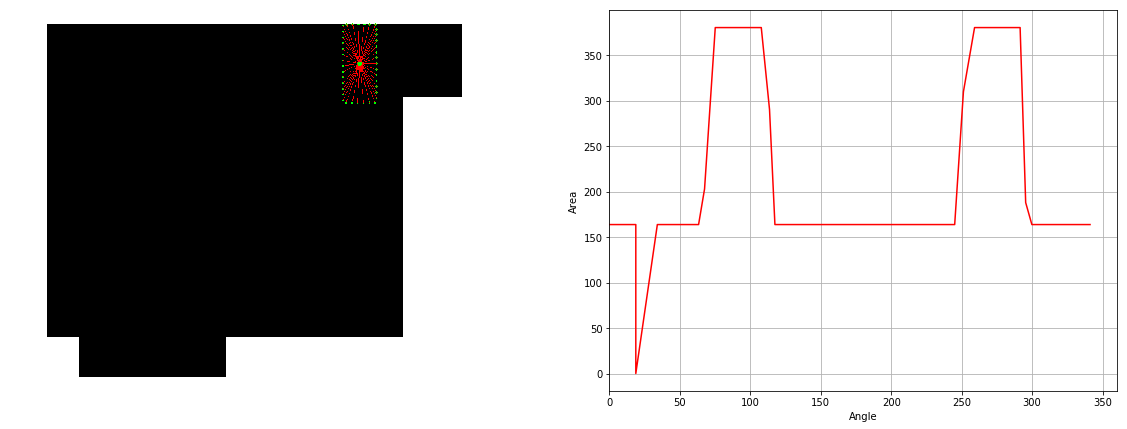

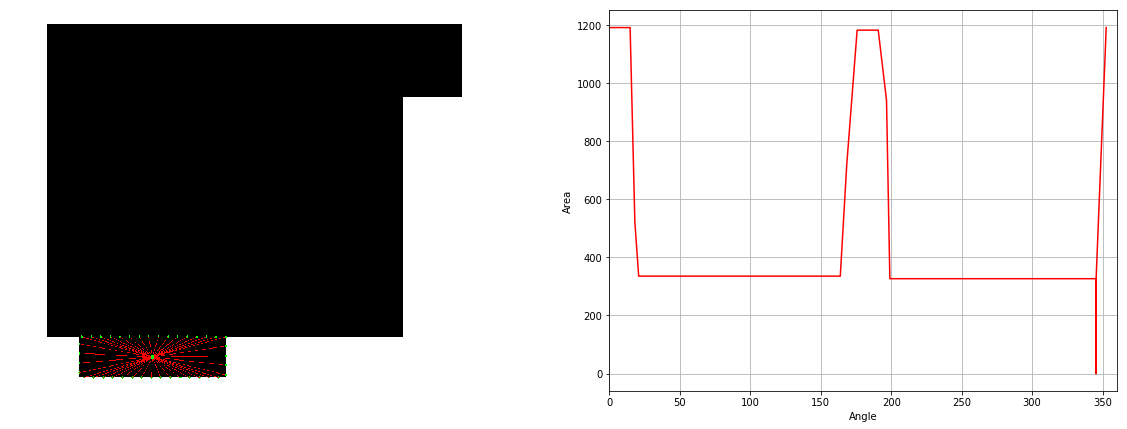

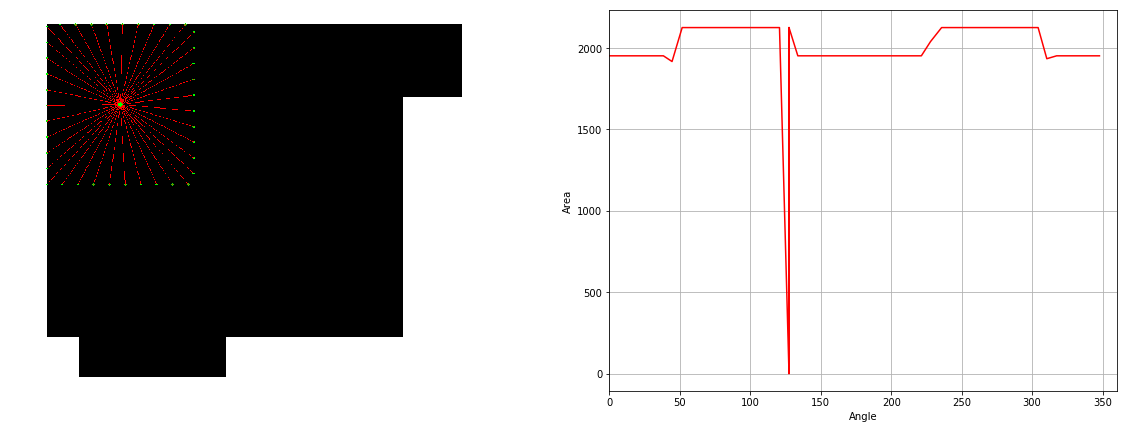

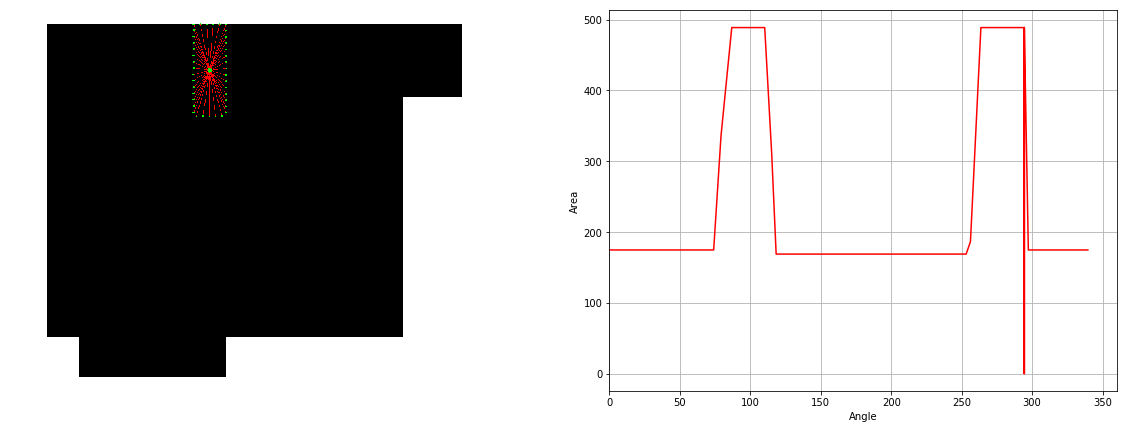

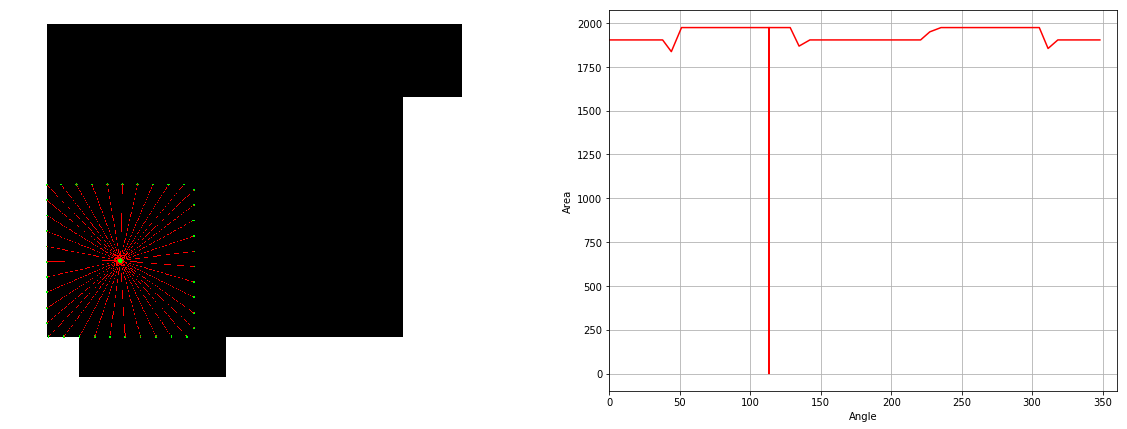

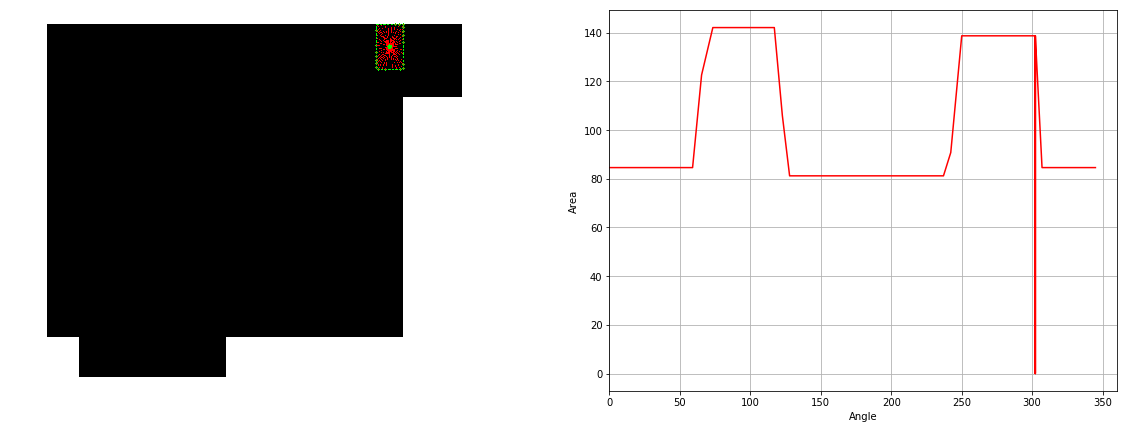

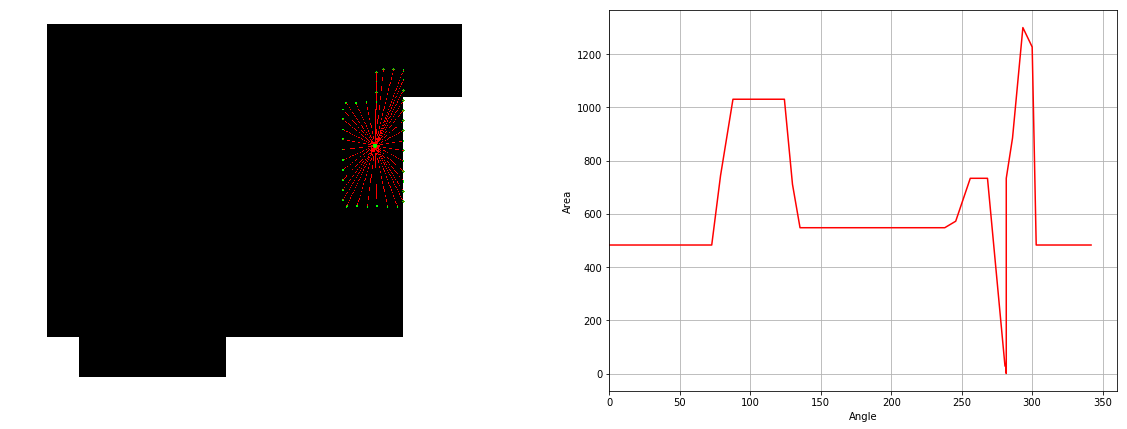

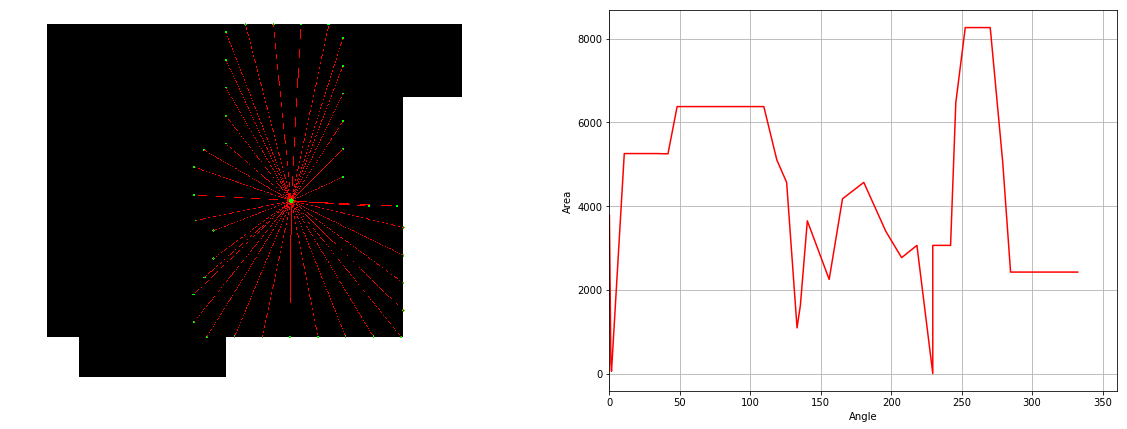

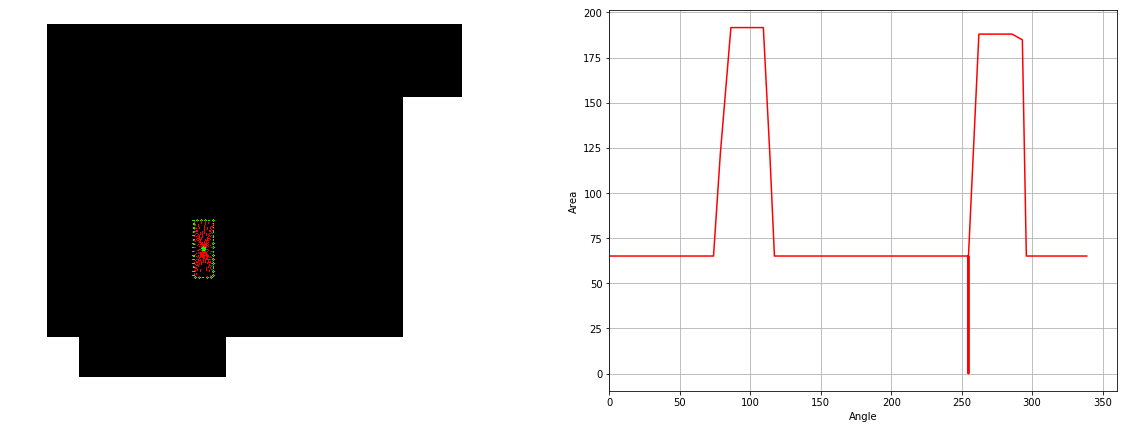

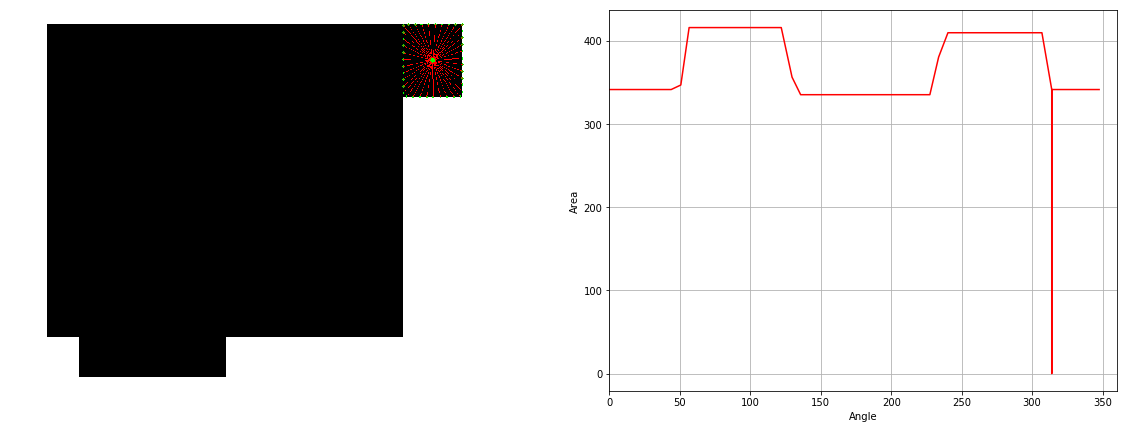

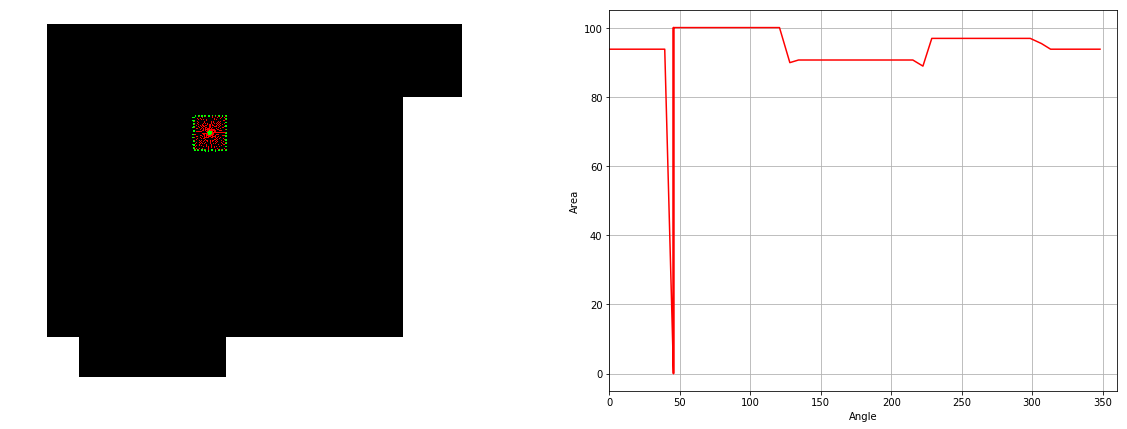

In [42]:
Angles,Areas = get_convexity_rooms(120, print_ = True)